# SHIP: Spiking (neural network) Hardware In Pytorch
SHIP is a simple and easy-to-learn emulation platform, intended to help designing and testing hardware-based SNN. It relies on phenomenological or compact models to mimic the behavior and functionalitites of the SNN components (neurons, synapses, etc.). It depends on a PyTorch backend: this choice comes from PyTorch availability of already-optimized matricial handling routines, but most of all because it allows SHIP to integrate PyTorch's conventional machine-learning techniques.

## Platform description 
The models are constructed as a set of time-discrete equations, each applicable to a _group_, i.e. set of hierarchically-identical components of the SNN (neurons and synapses; but also, optionally, learning rule circuit blocks, dendritic integrators, etc.). An easy-to-amend model scaffold is provided, to facilitate the building step of bespoke models.

The temporal progress follows a clock-driven approach, using either a fixed time-step or allowing the user to program time-step changes along the inference.

The group models are all called sequentially during each time-step. The sequence is determined by an ad-hoc routine that minimizes computational artefacts (which are likely for complex, recurrently-connected networks). The data flow across the groups is managed in a supervised approach, though an initialization function (called before the first inference) does most of the job and minimizes any further overhead. 

We note that recurrent networks can be defined in SHIP with the same models used for feedforward network, with no added complexity.

## Interface 
The interface is minimal, yet naturally readable. Network building starts with the instation of an "empty" network. The user can then add the group models, eventually providing both the configurational parameters for each group, and the group's sources and targets. The latter defines the network structure.

The user would then initialize the network, so to consolidate the network object and its inner clockwork.
Eventually, the user can perform inference, optionally providing input data.

Also, the user can set-up a trainer object, which takes care of interfacing the network object in SHIP with the PyTorch training algorithms.

A few utilities are also provided to facilitate provision, conversion and handling of datasets.

## Citation
A manuscript preparation is underway, by the provisional title of "Challenges and solutions for the emulation of silicon spiking neural network systems" from Emanuele Gemo, Sabina Spiga, and Stefano Brivio. The target journal is Frontiers In Neuroscience.

# Using SHIP: Short tutorial
This section shows how to use SHIP to build a network, perform simulations of its temporal evolution, and eventually submit external inputs and train the system towards a certain classification task.

## Preliminary information

### Data convention
First and foremost, we underline the convention by which SHIP reads and generates data.
Data containing a temporal axis, such as the network input and output, is assumed to be a tensor of the following size:
(batch_size, nts, nU).
* batch_size is the number of parallel runs that the simulator carries out.
* nts corresponds to the discretization of the temporal axis (number of time-steps).
* nU number of Units) is the number of components of a given group. We note that this value can change for each group in the simulated network.

In case of a missing temporal axis (e.g. data generated from a group, for a single time-step), the mid dimension is simply omitted, condensing the data to (batch_size, nts).

### Notation through the notebook
We will refer to the class or objects using the **bold** notation. Arguments of the class methods will be highlighted using the *italic* notation.

### Preliminary actions
We add the module folder to our working directory:

In [7]:
import sys
sys.path.append('C:\\') # to be edited

## Network building and inference

### Instate a network object
We here illustrate how to generate and simulate a network. 
We first import the necessary class, and instate an empty network "net", using the **network** class:

In [8]:
from SHIP import network
net = network()

### Add groups
After the object instantiation, we can start adding our groups of components.
We initially see an example that uses a Poisson spike generator as the driving force for the network temporal evolution. We import the corresponding class, here **poissonN**, and add it as a group to our network, using the ```network.add``` method:

In [9]:
from SHIP import poissonN
net.add(poissonN, 'P')

The ```network.add``` method requires two mandatory positional arguments: the group *class*, and the group *tag*. In the example above, we provided the class **poissonN** as the first argument, and the name 'P' as the group *tag*. We underline that each tag must be unique, as those will be essential to handle each unique group within the network.

### Set group parameters
The group models here provided come with pre-defined parameters. However, it is of course highly important to tune the parameters of each group or component according to the desire of the user.

At this stage of the development, there is no built-in method that evidences which variables, functions and parameters can be provided during the building stage. We assume that the user can read the model source to rapidly determine those.

The most important parameter is the number of components of the group, *N*, which must be provided in order for SHIP to know how many units to initialize. Another argument is the firing rate *rate*, at which each component spikes.

A way forward to set these parameters is to pass the correlated keyword arguments to the ```network.add``` method. However, The same operation can be carried out in a second moment, by using the ```network.set_params``` method. We give an example below:

In [10]:
net.set_params('P',N=5,rate=100)

With this instruction, the 'P' group now contains 20 units, firing at the fixed rate of 100 Hz.
Let's add a second neuron group, named 'O', using the leaky integrate neuron model **liN**. We pass as keyword arguments the number of units *N* = 2, and the temporal constant *tau_beta* = 20ms:

In [11]:
from SHIP import liN
net.add(liN, 'O', N=2, tau_beta = 20e-3)

Here we defined a group and all its necessary arguments in a single line.
We underline that any argument passed to the network, or internal state, can be retrieved at any time through the property ```groups``` of the **network** object. ```network.groups``` is a dict data structure, where each key give access to the properties of each group. 

The dict is here modified so to allow using a more convenient dot notation. Thus, any accessible variable can be retrieved using a nested dot notation. 
For instance, we can retrieve the value of ```tau_beta``` of 'O' as follows:

In [12]:
net.groups.O.tau_beta
# alternatively: net.groups['O'].tau_beta

AttributeError: 'liN' object has no attribute 'tau_beta'

### Add synapse groups: create connections between neuron groups
The models of the groups above, **poissonN** and **liN**, are defined as ```neurongroup```, i.e. groups that require the defintion of the number of units *N*, and in a conventional network graph representation would correspond to the nodes.

We now want to connect those by way of a synapse model. 
It is possible to do so by importing the desired class, and adding an additional group in very much the same way as done above, with few exceptions. Connections between ```neurongroup``` groups can be carried out by using ```synapsegroup``` groups, which in a conventional network graph representation, correspond to the graph edges. 

```synapsegroup``` require two additional keyword arguments with respect to ```neurongroup```: the synapse *source*, and the synapse *target* groups. The number of units, *N*, is instead determined automatically from the connected groups, as SHIP emulates a fully-connected network by default.

We also note that the connection is directed, i.e. signals are carried out exclusively from the source to the target.

We show an example that uses the 2nd order leaky synapse model, here **lS_2o**, also passing as arguments the two temporal constants that specify the model's dynamic behavior, here *tau_alpha1* and *tau_alpha2*.

In [13]:
from SHIP import lS_2o
net.add(lS_2o, 'PO', # class and tag are again mandatory
        source = 'P', target = 'O', # synapse groups eventually require to define source and target
        tau_alpha1 = 8e-3, tau_alpha2 = 4e-3) # group model's parameters.

We underline that no value for the synaptic weights is here passed, though a parameter *w* can indeed be passed as an argument.
By design, the lS_2o model defines a uniform random distribution between the values of 0 and 1, unless otherwise specified by the user.

### Initialize the network

At this point we now have a proper network, consisting of a Poissonian source 'P', a leaky and integrate neuron model 'O', and a set of synaptic connections 'PO'.

In order to run a simulation, we need to i) initialize the network using the ```network.init``` method, which calls a set of internal routines that properly set up the **network** object; and ii) provide the number of batches ```batch_size```, the number of time-steps ```nts```, and the size of the time-step, ```dt```.

We can do all of it as follows:

In [14]:
bs = 1 # batch size
nts = 100 # number of time-steps
dt = 0.001 # size of the time-step

net.init(batch_size = 1, dt = dt, nts = nts)

At this stage we have a **network** object ready to support the simulation of its temporal evolution for a duration of ```nts``` timesteps of size ```dt```.

### Define an output
It would be possible to already run a simulation; but, by default, the **network** object does NOT store any information along the temporal simulation, unless explicitly required by the user.

There are two ways to do so. One is the definition of a **network** output. Doing so, **network** ackowledges that its output corresponds to the one of a group, as expressed by the user. To do so, we define the argument *is_output* as ```is_output = True``` during the group declaration stage, or using the ```network.set_params``` method. 

See example below, where we define the network output as the **liN** group output:

In [15]:
net.set_params('O', is_output = True)
net.init()

Also remember to initialize the network again (provision of *batch_size*, *dt*, *nts* arguments is not required again, as those are stored permanently during any of the previous initialization calls).

### Run the simulation

At this stage, the network can simulate a temporal evolution AND store the data in the ```network.output``` property.

To run the simulation, we call the ```network.run``` method:

In [16]:
net.run()

Here we show the shape of the results gathered after the simulation:

In [17]:
net.output.shape

torch.Size([1, 100, 2])

and we plot what the simulation determined against the temporal axis, which can be recalled by using the ```network.timeline``` method:

Text(0, 0.5, 'liN membrane potential [abs.]')

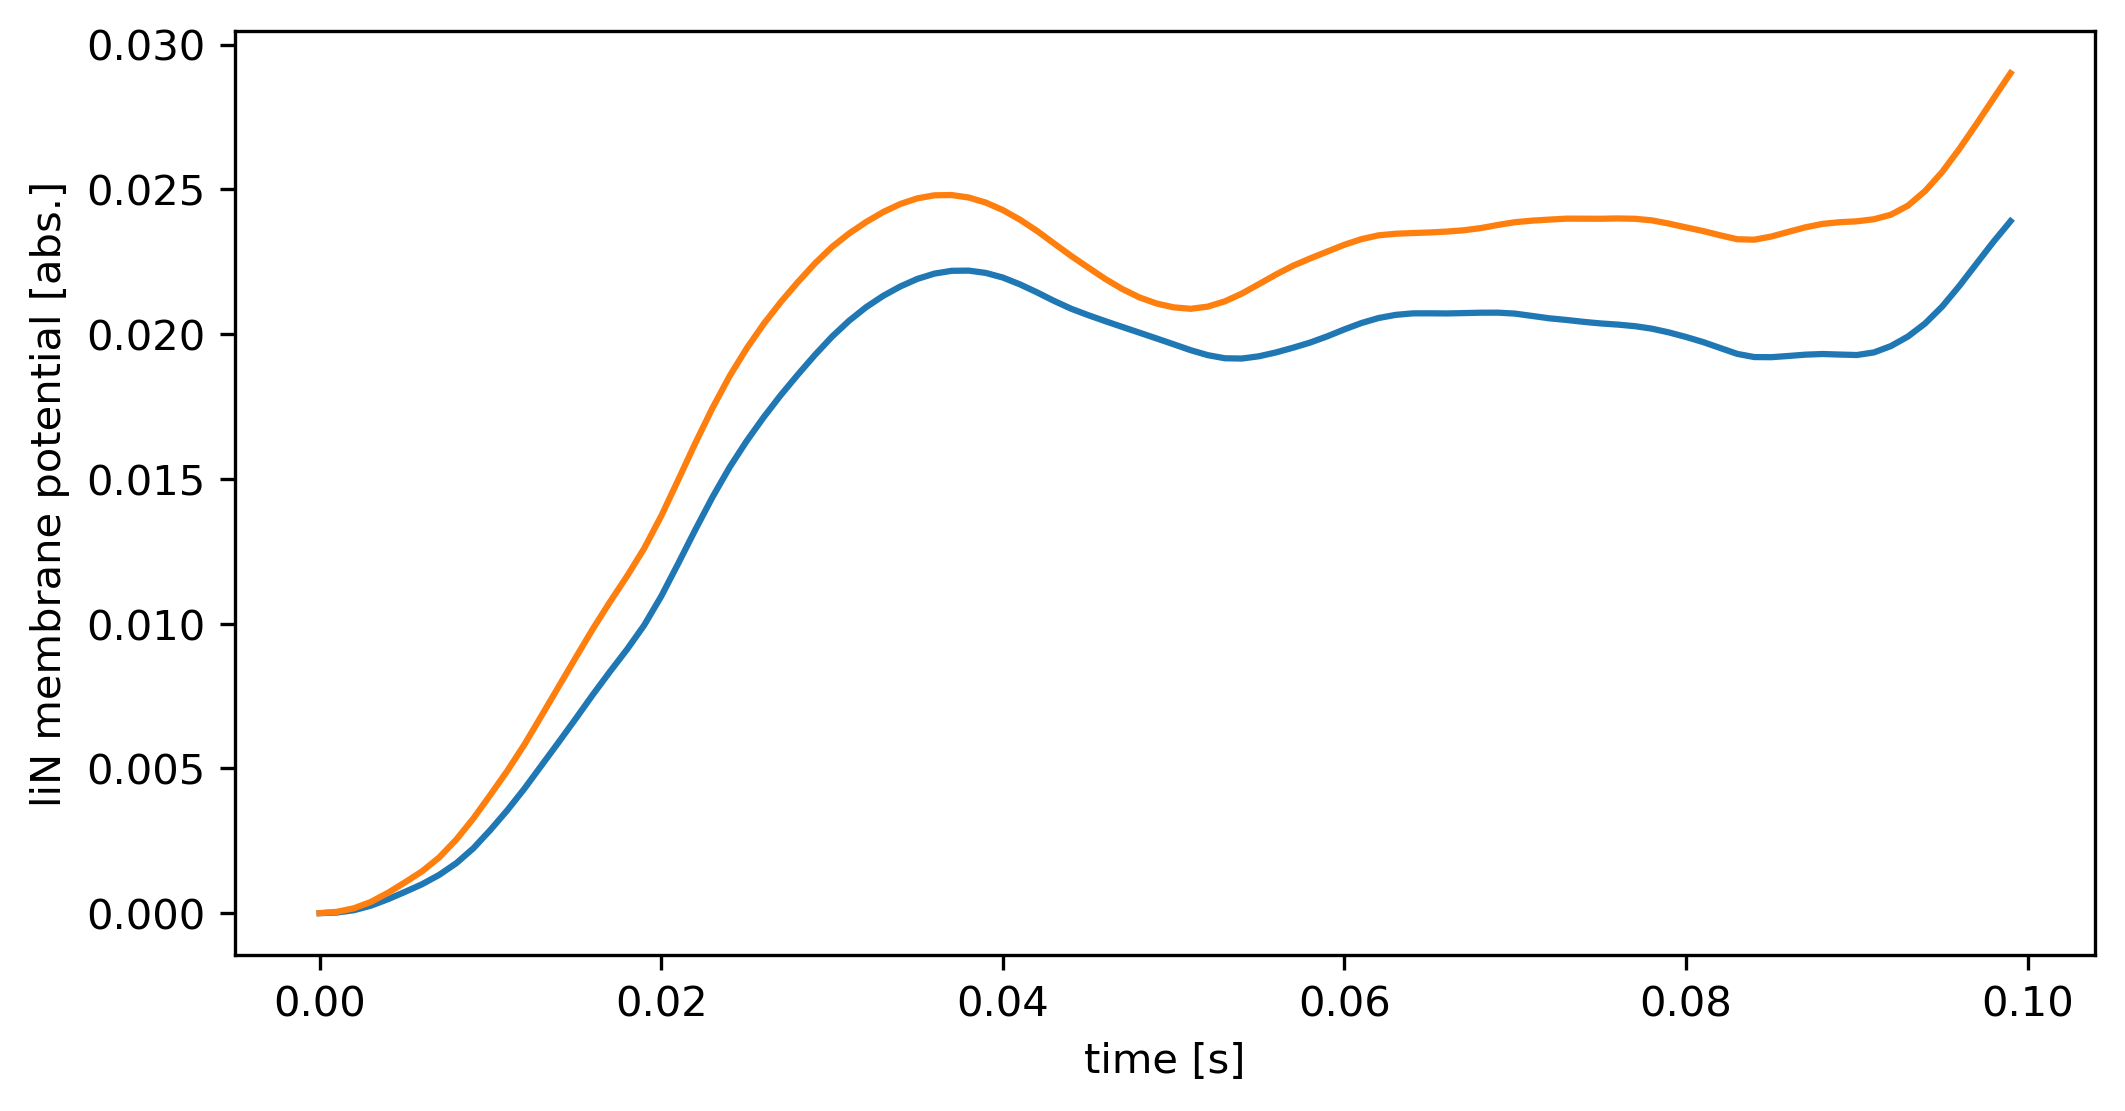

In [18]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,1, dpi = 300, figsize = (8,4))
ax.plot(net.timeline(), net.output[0,:,:])
ax.set_xlabel('time [s]')
ax.set_ylabel('liN membrane potential [abs.]')

### Set monitors and retrieve monitored data
We repeat the simulated experiment, here though with the need to track what the input spikes look like, an how the synapse current evolves thorugh time. 

To conserve the memory of any of the network parameters or variables, we need to use the ```network.set_monitor``` method. This method set a wrapper function that catches the group's output at each timestep, and store it permanently. Its (positional) arguments are the name of the group and the name of the desired variable/parameter, all in string format (lists of strings can also be used). 

To gather the results, we use the argument-less method ```network.get_monitored_data```.

We repeat the experiment above and plot the simulated results, this time tracking the poisson spikes, which are the output of the **poissonN** model; and the current state of the synapse model **lS_2o**

We underline that monitors require the user to state the name of any variable or parameter of the model of a network's group; however, the model output can also be stored in the same way, regardless of the presence of an ad-hoc variable having such a role.

See example below:

In [19]:
net.set_monitor(**{'P':['output'],'PO':['I1','I2']})
# alternatively one can set one variable at a time, without using lists
# net.set_monitor('P','output')
# net.set_monitor('PO','I1')
# net.set_monitor('PO','I2')

net.run()
data = net.get_monitored_results() # get all monitors
pSpikes = data.P.output # get_monitored_results() is a dictionary, accessible by dot notation, 
                        # where data is reachable as group_tag.variable_name
I = data.PO.I1+data.PO.I2


As visible above, the data returned by the ```get_monitored_results()``` method is a dictionary, modified to allow data access by using the dot notation in place of the conventional square-braket notation. 

Each element in the dictionary has the same key (name) as the group tag (e.g. data.P contains the results of the group 'P').

Each value is again a dictionary, containing the simulation results structured in the same way (here, the key corresponds to the monitored variable/parameter).

Thus, the returned value of data is essentially a tree where each branch correspond to the monitored groups, and each leaf corresponds to the monitored variables of the monitored groups. We note that the assumption underpinning this methodology is that each monitored variable is numeric.

We plot our results below:

(-0.001, 0.101)

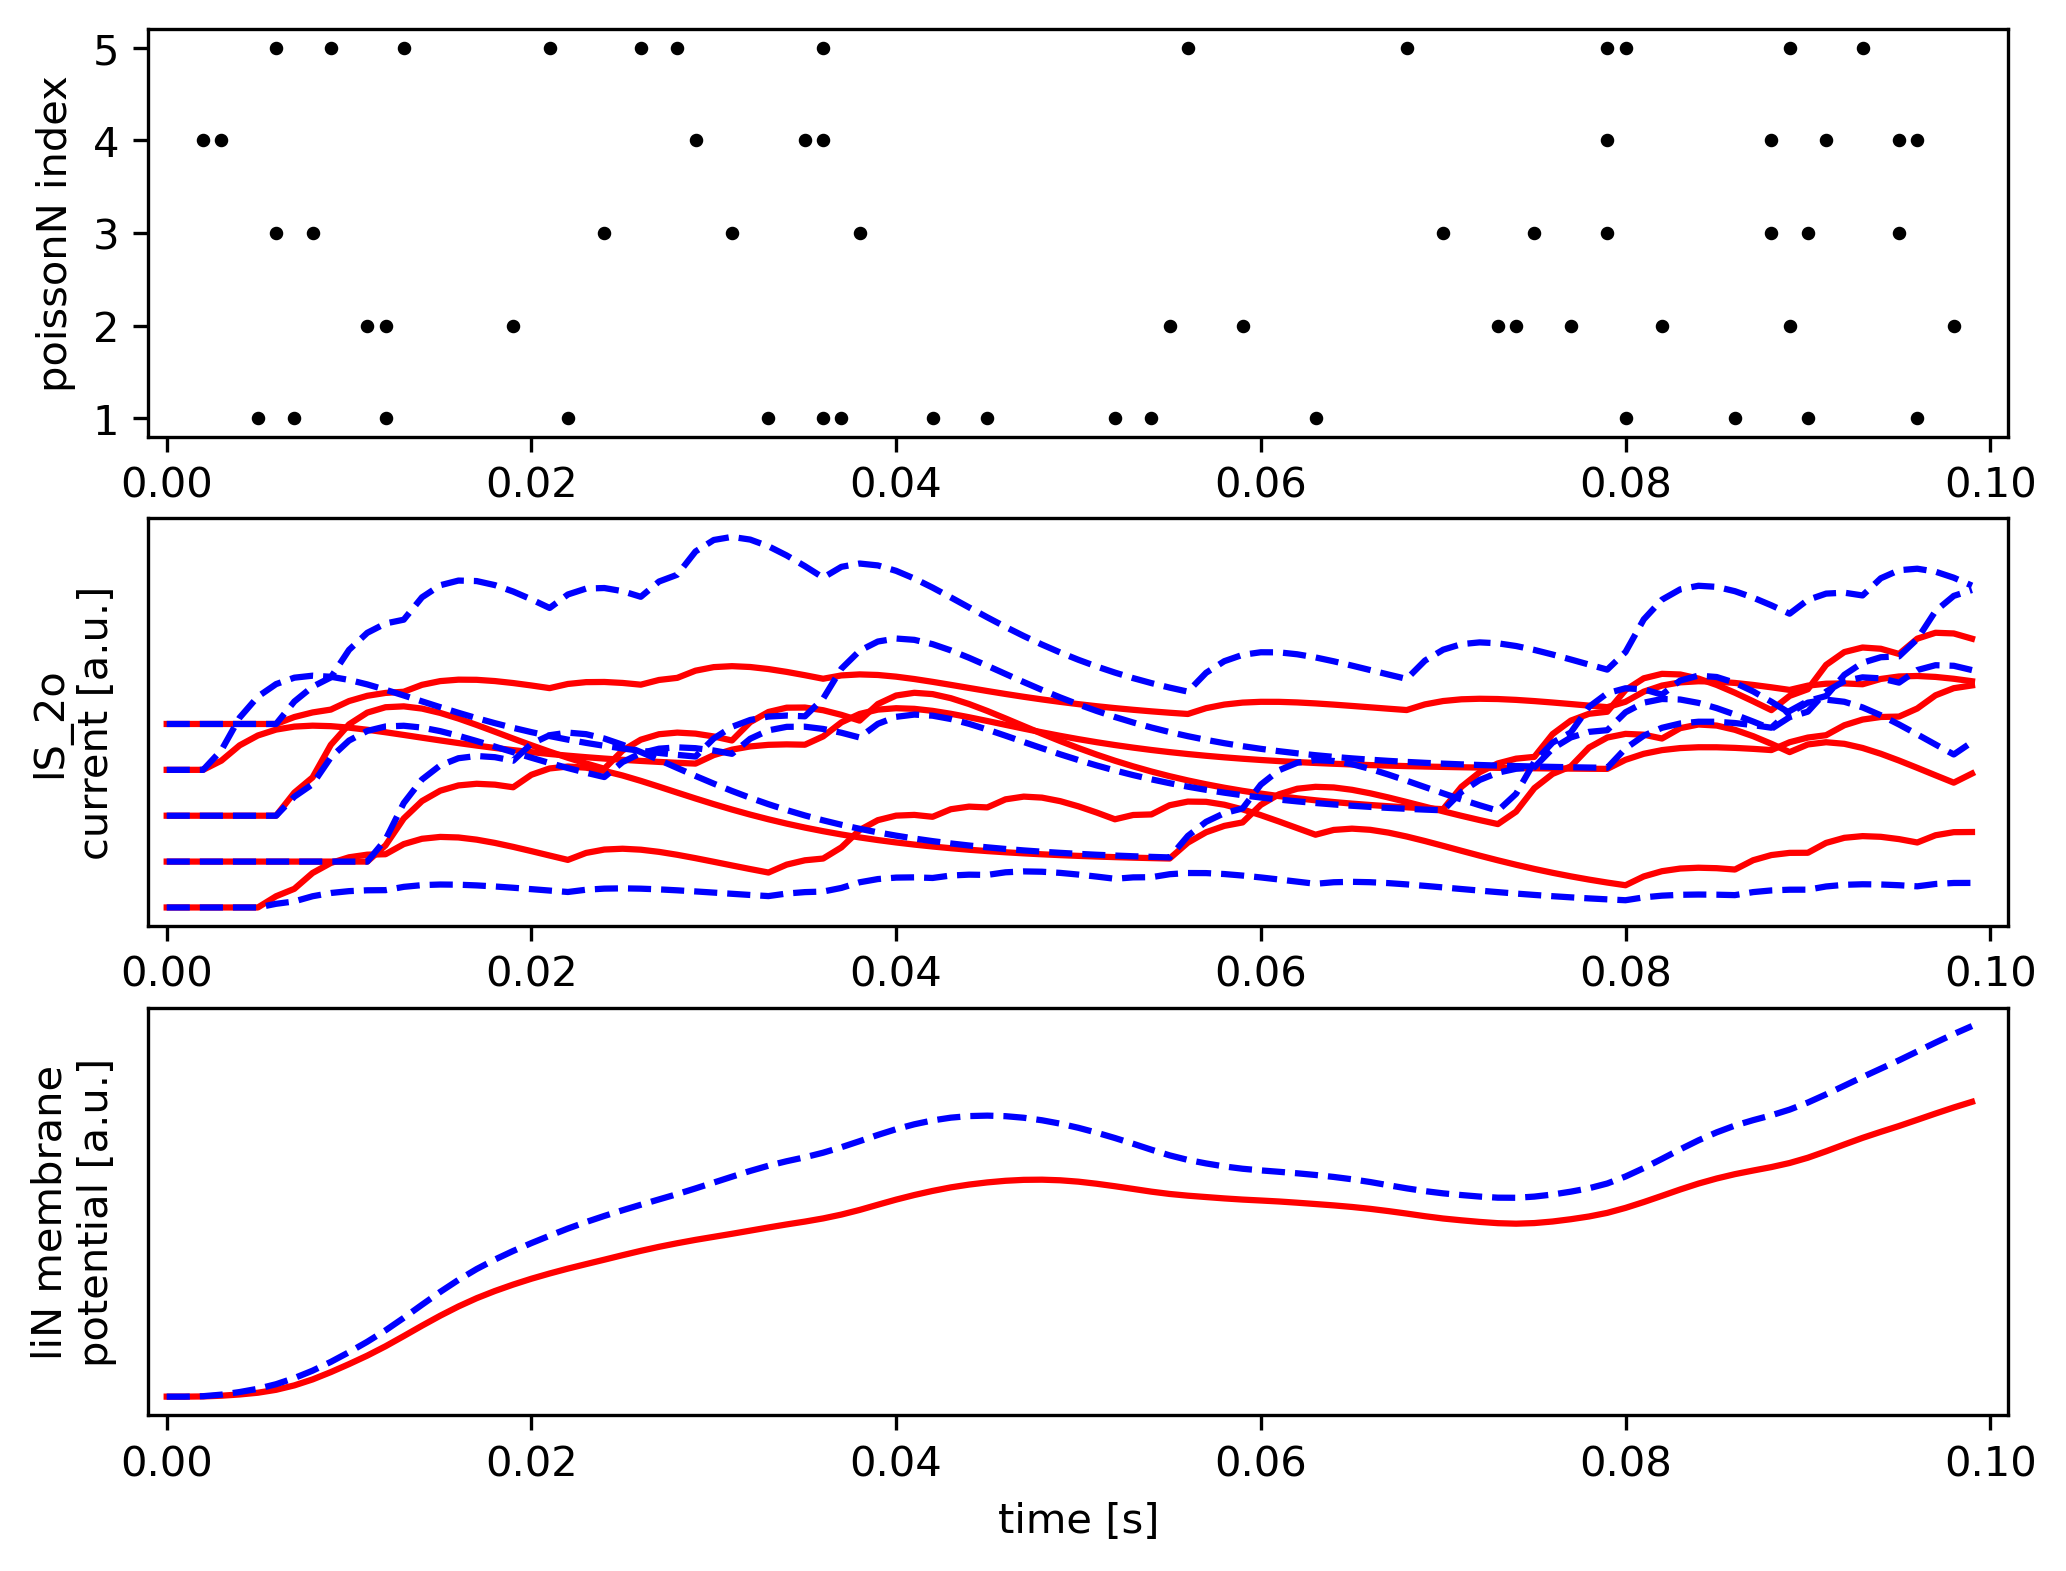

In [23]:
f,ax = plt.subplots(3,1, dpi = 300, figsize = (8,6))


# poissonN spikes
nU = net.groups.P.N # retrieval of 'P' number of components
xx = net.timeline().unsqueeze(1).expand(nts,nU)[pSpikes[0,:,:]]
from torch import arange
yy = arange(1,nU+1).unsqueeze(0).expand(nts,nU)[pSpikes[0,:,:]]
ax[0].scatter(xx,yy,s=5,color = [0,0,0])
ax[0].set_ylabel('poissonN index')
ax[0].set_yticks(arange(1,nU+1))
ax[0].set_xlim([-dt,(nts+1)*dt])

# lS_2o synaptic current
offset = 1/nU*arange(1,nU+1).unsqueeze(0).expand(nts,nU)
ax[1].plot(net.timeline(), I[0,:,:,0]+offset, color='r')
ax[1].plot(net.timeline(), I[0,:,:,1]+offset, linestyle = 'dashed',color='b')
ax[1].set_ylabel('lS_2o\ncurrent [a.u.]')
ax[1].set_yticks([])
ax[1].set_xlim([-dt,(nts+1)*dt])

#liN membrane potential 
ax[2].plot(net.timeline(), net.output[0,:,0], color = 'r')
ax[2].plot(net.timeline(), net.output[0,:,1], linestyle = 'dashed', color = 'b')
ax[2].set_xlabel('time [s]')
ax[2].set_ylabel('liN membrane\npotential [a.u.]')
ax[2].set_yticks([])
ax[2].set_xlim([-dt,(nts+1)*dt])

### Use of wrapper functions to add functionalities
This platform allows to use wrapper functions to include functionalities otherwise not defined within a model.
We show a couple of important examples that use this strategy: definition of a refractory functionality on a lif neuron, and definition of a delay time on a synaptic model.

Refractoriness can be included by way of the ```refractory``` function. This applies to any neuronal model that uses the *integrate* variable to assess whether to integrate the incoming input. An alternative function, ```refractory_variabletimestep```, perform the same function, with a different algorithmic implementation. Future version will likely merge the two function into one. The latter has been developed specifically to add this functionality also in case of a variable-timestepping approach.

Delay functionality is added by way opf the ```delayed``` function (no variabletimestep version present as of yet).

We take the network above, we add a few more groups (**lifN** simple lif neurons, and **lS_1o** 1st order leaky synapses). We add to those the refractory and delay functionality.

In [24]:
from SHIP import (lifN,
                  lS_1o,
                  refractory_variabletimestep as refr,
                  delayed)
net.add(refr(lifN),'N',N=2,tau_beta_ = 0.03, thr = 0.02, refr_time = 0.02)
net.add(lS_1o,'PN',source='P',target='N')
net.add(delayed(lS_1o),'NO',source='N',target='O',delay_time = 0.02)
net.init()

We monitor the **lifN** group membrane potential *u* and output, as well as the output of the 'NO' **lS_1o** group, to observe the refractoriness and delay in action. We run the simulation and plot the output:

(-0.001, 0.101)

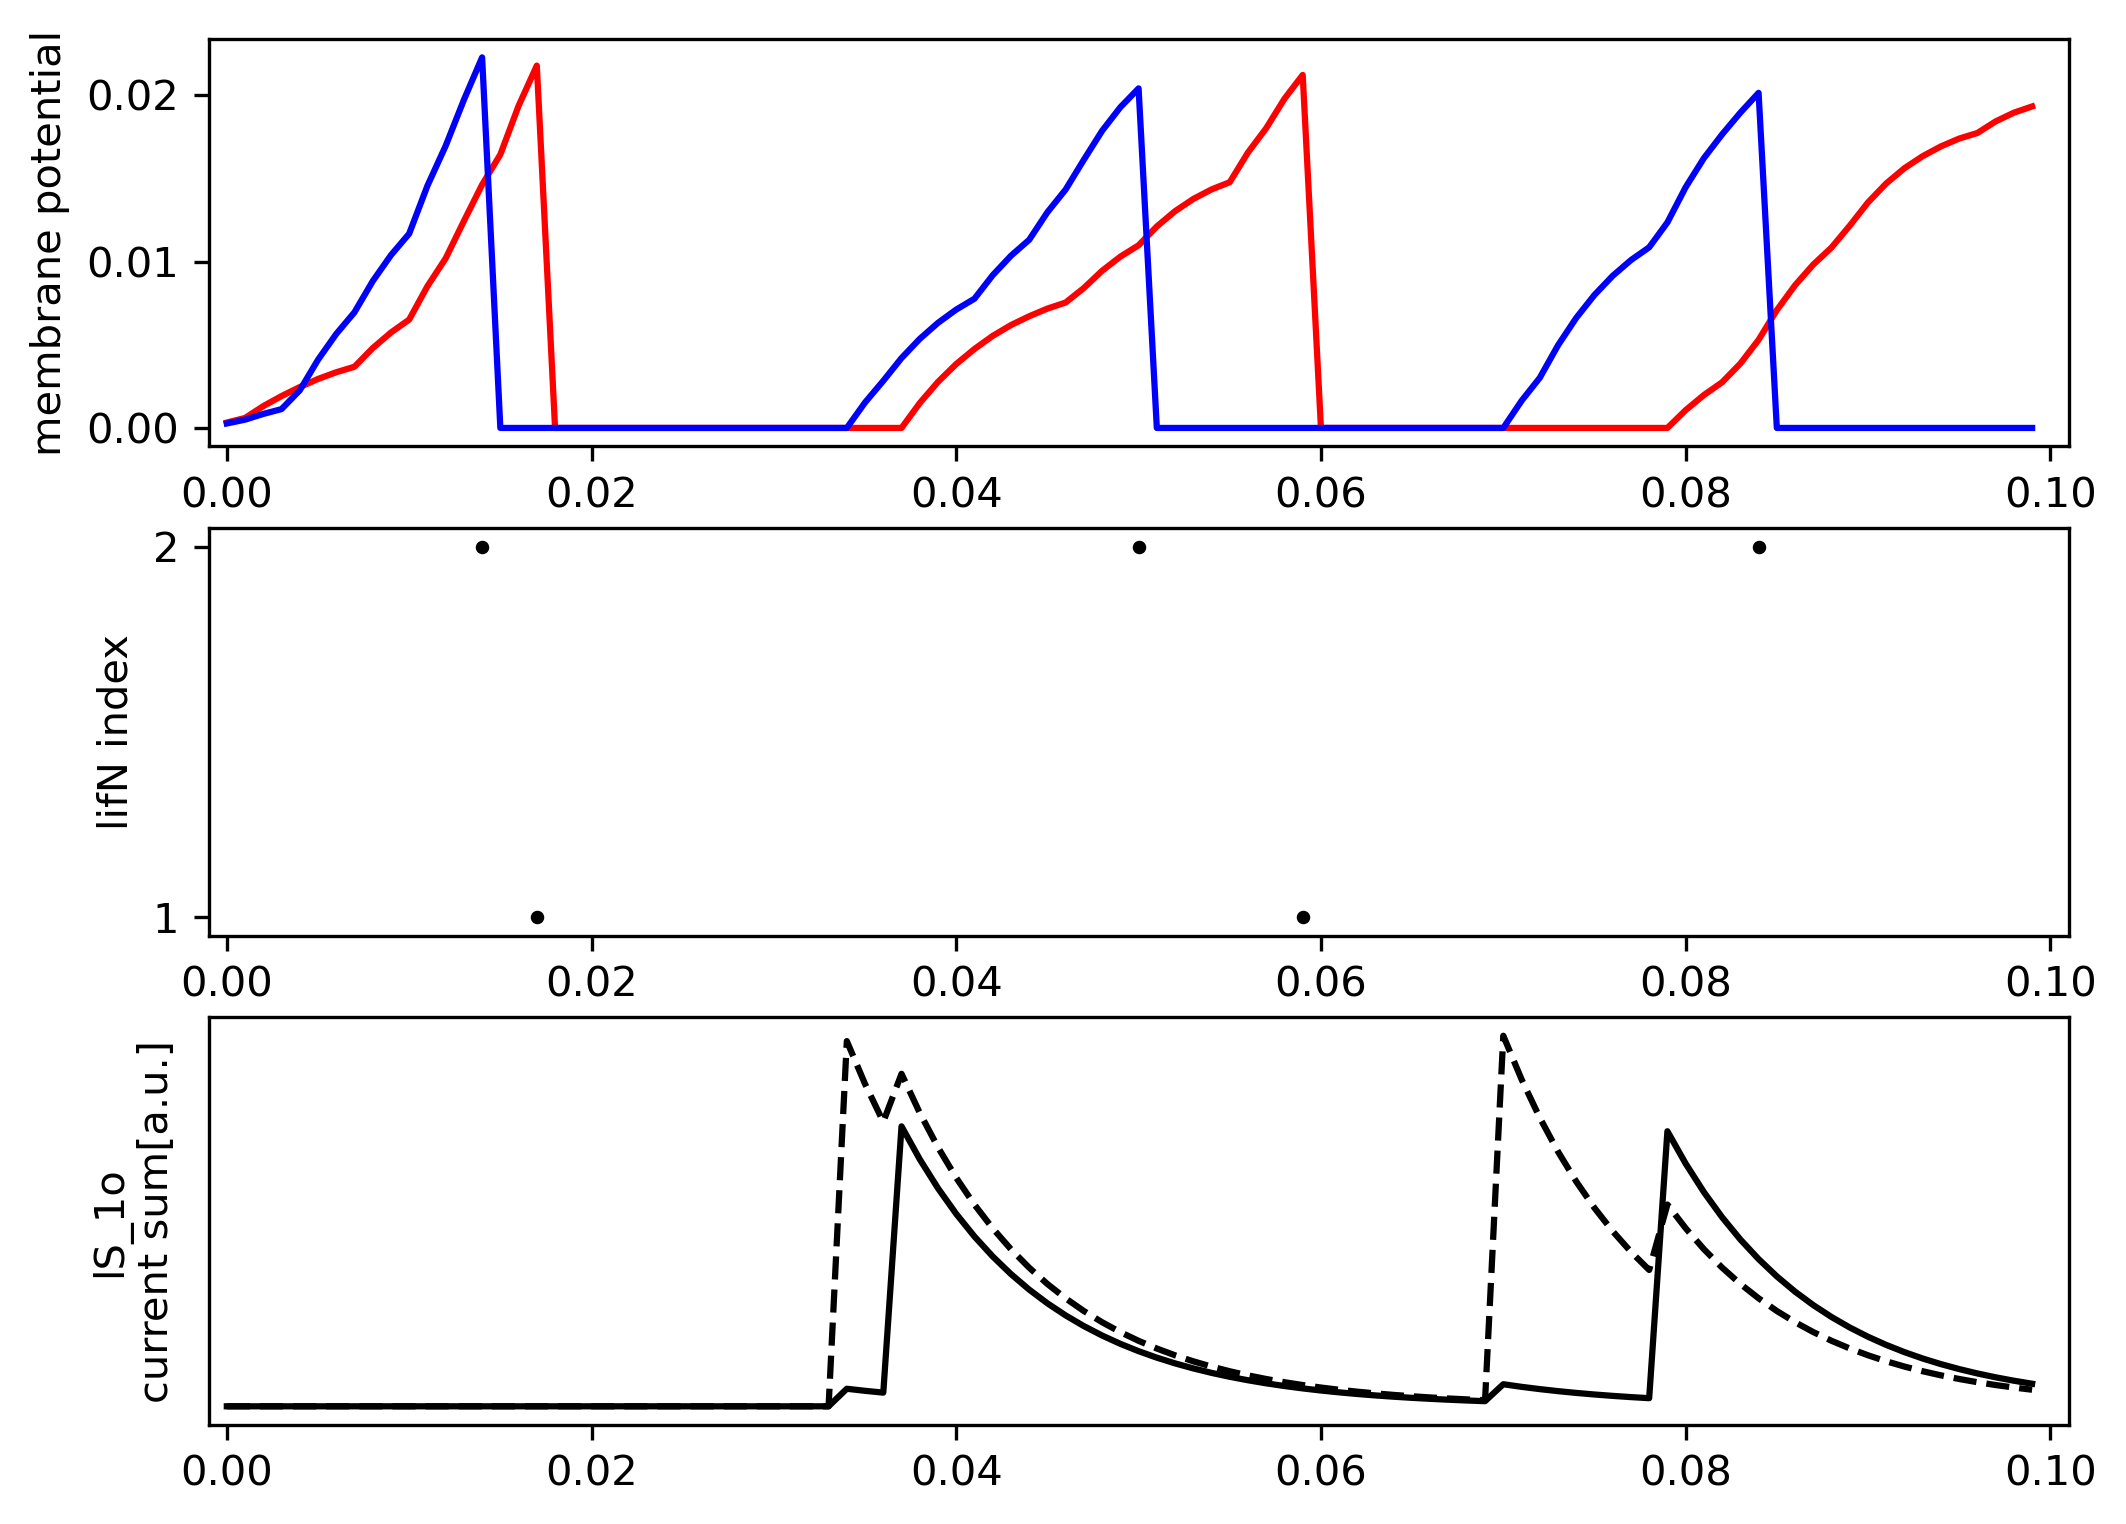

In [25]:
net.set_monitor(**{'N':['u','output'],'NO':['output']})
net.run()

data = net.get_monitored_results()

f,ax = plt.subplots(3,1, dpi = 300, figsize = (8,6))

# lifN membrane potential

ax[0].plot(net.timeline(), data.N.u[0,:,0],color = 'r')
ax[0].plot(net.timeline(), data.N.u[0,:,1],color = 'b')
ax[0].set_ylabel('membrane potential')
ax[0].set_xlim([-dt,(nts+1)*dt])

# lifN spikes
lSpikes = data.N.output
nU = net.groups.N.N # retrieval of 'N' number of components
xx = net.timeline().unsqueeze(1).expand(nts,nU)[lSpikes[0,:,:]]
yy = arange(1,nU+1).unsqueeze(0).expand(nts,nU)[lSpikes[0,:,:]]
ax[1].scatter(xx,yy,s=5,color = [0,0,0])
ax[1].set_ylabel('lifN index')
ax[1].set_yticks(arange(1,nU+1))
ax[1].set_xlim([-dt,(nts+1)*dt])

# lS_2o synaptic current
I = data.NO.output
ax[2].plot(net.timeline(), I[0,:,0], color='k')
ax[2].plot(net.timeline(), I[0,:,1], linestyle = 'dashed',color='k')
ax[2].set_ylabel('lS_1o\ncurrent sum[a.u.]')
ax[2].set_yticks([])
ax[2].set_xlim([-dt,(nts+1)*dt])

It would hopefully be evident how the refractory period of 20 ms, and the delay time of 20 ms, impact the dynamic behavior of the two models here show. 

### Syntetic argument notation: values as function generators
A unique functionality of this platform is the rapid generation of any arbitrary distribution, in function of the number of components of the group and/or the number of parallel batches that the user is willing to simulate.

We highlight this through an example. Let's assume that the user wants to define a randomly-generated set of values for the threshold membrane potential *thr*, along the indices of a **lifN** group. The user can externally define the set of values and pass those as a static argument. However, a more convenient way uses the internal data parsing that can treat all arguments as generator function. See below:

In [26]:
# static argument method
from torch import rand
net.add(lifN,'N_static',N = 5, 
        thr = rand(5))

# dynamic data generation
net.add(lifN,'N_dynamic',N = 5,
        thr_ = rand)

Note the subtle change of the variable name *thr*. The static method defines a set of values once, during the declaration phase, and repeated initializations/simulations would never change the values there defined.

Instead, the dynamic method adds one underscore AFTER the *thr* key, and provide exclusively the function. In such a way, the platform stores a generator function (rand), along with the information that the function argument is the number of components *N*. #

See below:

In [27]:
print ('first call.')
net.init()
print('static method: theshold values = ',net.groups.N_static.thr)
print('dynamic method: theshold values = ',net.groups.N_dynamic.thr)

print ('second call.')
net.init()
print('static method: theshold values = ',net.groups.N_static.thr)
print('dynamic method: theshold values = ',net.groups.N_dynamic.thr)



first call.
static method: theshold values =  tensor([0.9812, 0.0902, 0.6378, 0.8906, 0.8331])
dynamic method: theshold values =  tensor([0.1996, 0.2487, 0.0139, 0.2831, 0.9126])
second call.
static method: theshold values =  tensor([0.9812, 0.0902, 0.6378, 0.8906, 0.8331])
dynamic method: theshold values =  tensor([0.3641, 0.0088, 0.5668, 0.6533, 0.1180])


Note the different values in the case of the dynamic method.

One can use two underscores in place of one, in case one needs a range of values determined as a function of the number of components of the *source* group and *target* group. This comes useful for ```synapsegroup``` groups, in which the models are generally tuned to work with a 2D matrix of variables, of size determined by the number of source and target components.

See below, where we generate a (uniformly-distributed) random set of values, comprised between 0 and 1, for the temporal constant of the synapse group connecting the lif groups above:

In [29]:
net.add(lS_1o,'S_dynamic',
        source = 'N_static',
        target = 'N_dynamic',
        tau_alpha__ = rand)

Lastly, another option is to place an underscore AFTER the desired key. Doing so, the algorithm uses, as a function argument, the batch_size. This comes handy in case the user wants to define a raster of simulations, in which only one parameters changes across the batch. See below for an example:

In [30]:
from torch import rand, arange

fun = lambda b,s,t: arange(b).unsqueeze(-1).unsqueeze(-1).expand(b,s,t)/b+rand(s,t).unsqueeze(0).expand(b,s,t)
net.add(lS_1o,'batch_dynamic',
        source = 'N_static',
        target = 'N_dynamic',
        _tau_alpha__ = rand)